# 関数 save_fig：図の保存

In [2]:
!pip install japanize-matplotlib # グラフの文字で英語以外を使えるようにする

import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def save_fig(plt, file_prefix, bbox_inches='tight'):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches=bbox_inches, pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches=bbox_inches, pad_inches = 0.2)

import sys
from datetime import datetime

def dmcode():
    t = datetime.now().timestamp()
    buff = ['***DMCODE', str(t)]
    print(' '.join(buff))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=762ee68b6032d9596cd5fa6e7e85f8f6b41a32b2b63c25172756a05050adfbf6
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


# 関数 plot_data2d：2次元データをプロットする

In [3]:
def plot_data2d(x_train, y_train, x_test, y_test, file_prefix=''):
    """2次元データをプロットする
    Args:
        x_train (ndarray): 訓練データの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_train (ndarray): 訓練データのクラス
        x_test (ndarray): テストデータの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_test (ndarray): テストデータのクラス
        file_prefix (str): グラフの保存先パス
    """
    colors=['coral', 'cornflowerblue']
    # 訓練データのマーカー。クラス0とクラス1
    markers=['o', 'o']

    plt.figure(figsize=(12, 6))

    def plot(x, y, title):
        # データのプロット
        for i in range(2):
            plt.scatter(x[y == i, 0], x[y == i, 1], c=colors[i],
                        marker=markers[i], edgecolor='black', s=100, label=f'クラス{i}')

        plt.title(title, fontsize=16)
        plt.xlim(35, 85)
        plt.ylim(35, 85)
        plt.xticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.yticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.xlabel('数学', fontsize=14)
        plt.ylabel('英語', fontsize=14)
        plt.grid()
        plt.legend(fontsize=14, loc='upper left')

    plt.subplot(1, 2, 1)
    plot(x_train, y_train, '訓練データ')

    plt.subplot(1, 2, 2)
    plot(x_test, y_test, 'テストデータ')

    plt.tight_layout()
    save_fig(plt, file_prefix)
    plt.show()

# 関数 plot_2class_result：2クラス分類結果をプロットする

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def plot_2class_result(x_train, y_train, x_test, y_test, model, file_prefix=''):
    """SVMによる分類結果を可視化する。
    Args:
        x_train (ndarray): 訓練データの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_train (ndarray): 訓練データのクラス
        x_test (ndarray): テストデータの点数。x[i, 0]: 数学の点数。x[i, 1]: 英語の点数
        y_test (ndarray): テストデータのクラス
        model (SVC): サポートベクトルマシン
        file_prefix (str): グラフの保存先パス
    """

    # 決定境界（直線）パラメータ w[0] * x[0] + w[1] * x[1] + w[2] = 0のw[0]とw[1]
    w = model.coef_[0]

    ns = model.n_support_ # サポートベクトルの数

    # サポートベクトルのx_trainにおけるインデックス
    svi = model.support_;

    # 分離直線の法線ベクトル
    normal_vec = np.array([w[0], w[1], model.intercept_[0]])

    # class 0のサポートベクトル
    mv0 = svi[margin_sv(normal_vec, x_train[svi[0 : ns[0]]], -1)]

    # class 1のサポートベクトル
    mv1 = svi[margin_sv(normal_vec, x_train[svi[ns[0]:]], 1, offset=ns[0])]

    mv_idx = np.array([mv0, mv1])

    # 訓練データの描画色。クラス0とクラス1
    colors = ['coral', 'cornflowerblue']
    sv_colors = ['red', 'blue']

    # 訓練データのマーカー。クラス0とクラス1
    markers=['o', 'o']

    plt.figure(figsize=(12, 6))

    # 分離直線
    a = -w[0] / w[1]
    xx = np.linspace(35, 85, 100)
    yy = a * xx - model.intercept_[0] / w[1]

    def plot(x, y, title):
        # 分離直線の描画
        plt.plot(xx, yy, color='black',linewidth=4, linestyle='solid')

        # データのプロット
        for i in range(2):
            plt.scatter(x[y == i, 0], x[y == i, 1], c=colors[i],
                        marker=markers[i], edgecolor='black', s=100, label=f'クラス{i}')

        # 分離直線に平行かつサポートベクトルを通る直線の描画
        # 訓練データから取得
        if mv_idx is not None:
            # w1(x1 - mv1) + w2(x2 - mv2) = 0
            # x2 = -w1(x1 - mv1) / w2 + mv2 = -(w1 / w2) x1 + (w1 / w2) * mv1 + mv 2
            for i in range(len(mv_idx)):
                sv = x_train[mv_idx[i]]
                plt.plot(xx, a * xx - a * sv[0] + sv[1], color='black',linewidth=4, linestyle='dashed')

        # サポートベクトルのプロット
        # 訓練データから取得
        for i in svi:
            sv = x_train[i]
            cls = y_train[i]
            plt.scatter(sv[0], sv[1], edgecolor='black', marker='o', s=400, color=sv_colors[cls],
                        linewidth=3)
        plt.title(title, fontsize=16)
        plt.xlim(35, 85)
        plt.ylim(35, 85)
        plt.xticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.yticks([35, 45, 55, 65, 75, 85], fontsize=14)
        plt.xlabel('数学', fontsize=14)
        plt.ylabel('英語', fontsize=14)
        plt.grid()
        plt.legend(fontsize=14, loc='upper left')

    plt.subplot(1, 2, 1)
    plot(x_train, y_train, '訓練データ')

    plt.subplot(1, 2, 2)
    plot(x_test, y_test, 'テストデータ')

    plt.tight_layout()
    save_fig(plt, file_prefix)
    plt.show()

# 関数 margin_sv：決定境界から最も離れたサポートベクトルを見つける

In [5]:
def margin_sv(w, sv, sign, offset=0):
    """決定境界から最も離れたサポートベクトルを見つける
    Args:
        w (ndarray): 決定境界のパラメータ。w[0] * x[0] + w[1] * x[1] + w[2] = 0
        sv (ndarray): あるクラスのサポートベクトル
        sign (int): クラスを識別する符号。クラス0に対しては-1、クラス1にたいしては+1

    Returns
        (int): svの中で決定境界から最も離れたサポートベクトルのインデックス
    """
    ds = np.zeros(len(sv))

    wlen = np.sqrt(w.dot(w))

    # サポートベクトルと決定境界との距離を計算
    for i, v in enumerate(sv):
        a = w[0] * v[0] + w[1] * v[1] + w[2]

        # 決定境界と他方のクラス側のマージンに含まれる点は符号がマイナスになる
        ds[i] = sign * a / wlen

    return np.argmax(ds) + offset

# 関数 plot_income_age：収入と年齢データをプロットする

In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib

def plot_income_age(x, y, file_prefix=''):
    """収入と年齢データをプロットする。
    Args:
        x (ndarray): 訓練データの説明変数
        y (ndarray): 訓練データの目的変数
    """
    xlim = (0, 1e7)
    ylim = (15, 60)
    xylabels = ['収入', '年齢']
    colors = ('coral', 'cornflowerblue', 'lightgreen', 'gray', 'cyan', 'blue', 'orange')
    markers = ('o', 'o', 'o', '^', 'v', '+', '*')

    cls = np.sort(np.unique(y))

    plt.figure(figsize=(6, 6))
    for i in range(len(cls)):
        plt.scatter(x[y==i, 0], x[y==i, 1], s=100, c=colors[i],
                    marker=markers[i], edgecolor='black', label=f'クラス{i}')

    if xylabels:
        plt.xlabel(xylabels[0], fontsize=16)
        plt.ylabel(xylabels[1], fontsize=16)

    if xlim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    plt.legend(scatterpoints=1, fontsize=14)
    plt.ticklabel_format(style='plain',axis='x')

    plt.grid()
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 plot_income_age_result：収入と年齢の分類結果をプロットする

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_income_age_result(x, y, model, xlim=None, ylim=None, file_prefix=''):
    """SVMによる収入と年齢の分類結果を可視化する。
    Args:
        x (ndarray): 訓練データの説明変数
        y (ndarray): 訓練データの目的変数
        model (SVC): サポートベクトルマシン
        file_prefix (str): グラフの保存先パス
    """

    w = model.coef_[0]

    ns = model.n_support_

    # サポートベクトルのx_trainにおけるインデックス
    svi = model.support_;

    # 分離直線の法線ベクトル
    normal_vec = np.array([w[0], w[1], model.intercept_[0]])

    # class 0の1個のサポートベクトル
    mv0 = svi[margin_sv(normal_vec, x[svi[0 : ns[0]]], -1)]

    # class 1の1個のサポートベクトル
    mv1 = svi[margin_sv(normal_vec, x[svi[ns[0]:]], 1, offset=ns[0])]

    mv_idx = np.array([mv0, mv1])

    # 訓練データの描画色。クラス0とクラス1
    colors=['coral', 'cornflowerblue']
    sv_colors = ['red', 'blue']

    # 訓練データのマーカー。クラス0とクラス1
    markers=['o', 'o']

    plt.figure(figsize=(6, 6))

    # 分離直線
    a = -w[0] / w[1]
    xx = np.linspace(x[:, 0].min(), x[:, 0].max(), 1000000)
    yy = a * xx - model.intercept_[0] / w[1]

    # 分離直線の描画
    plt.plot(xx, yy, color='black',linewidth=4, linestyle='solid')

    # 訓練データのプロット
    for i in range(2):
        plt.scatter(x[y == i, 0], x[y == i, 1], c=colors[i],
                    marker=markers[i], edgecolor='black', s=100, label=f'クラス{i}')

    # 分離直線に平行かつサポートベクトルを通る直線の描画
    if mv_idx is not None:
        # w1(x1 - mv1) + w2(x2 - mv2) = 0
        # x2 = -w1(x1 - mv1) / w2 + mv2 = -(w1 / w2) x1 + (w1 / w2) * mv1 + mv 2
        for i in range(len(mv_idx)):
            sv = x[mv_idx[i]]
            plt.plot(xx, a * xx - a * sv[0] + sv[1], color='black',linewidth=4, linestyle='dashed')

    # サポートベクトルのプロット
    for i in svi:
        sv = x[i]
        cls = y[i]
        plt.scatter(sv[0], sv[1], edgecolor='black', marker='o', s=250, color=sv_colors[cls],
                    linewidth=3)

    if xlim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    plt.ticklabel_format(style='plain',axis='x')
    plt.xlabel('収入', fontsize=14)
    plt.ylabel('年齢', fontsize=14)
    plt.grid()
    plt.legend(fontsize=14, loc='upper left')
    plt.tight_layout()
    save_fig(plt, file_prefix)
    plt.show()

# 実習8.1：外れ値のある2次元データの読み込み

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('dm8-1.csv', encoding='utf-8')

df

,クラス,数学,英語,種類
0,0,58,43,1
1,0,52,50,1
2,0,46,51,1
3,0,47,45,1
4,0,54,46,1
...,...,...,...,...
195,1,76,73,0
196,1,78,73,0
197,1,71,71,0
198,1,76,63,0


# 実習8.2：外れ値のある2次元データを可視化する

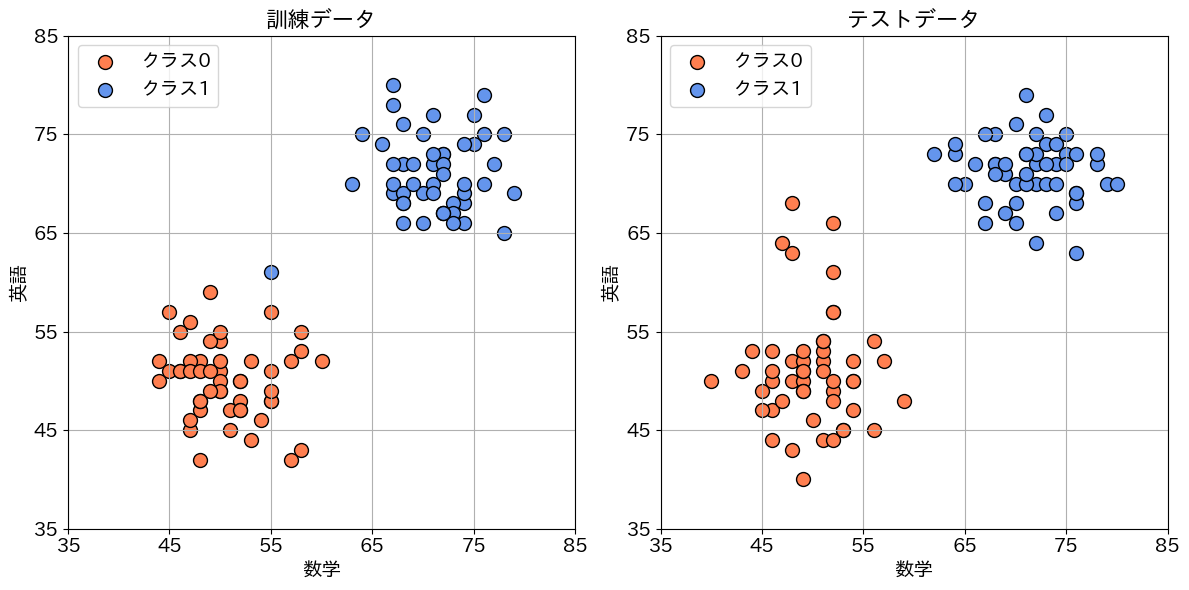

In [11]:
# 数学と英語の点をデータフレームから取り出す。Numpy配列へ変換
x=df[['数学', '英語']].to_numpy()

# クラスラベルを取り出す。Numpy配列へ変換
y=df['クラス'].to_numpy()

# 数学と英語の点をデータフレームから取り出す。Numpy配列へ変換
x=df[['数学', '英語']].to_numpy()
# クラスラベルを取り出す。Numpy配列へ変換
y_train=df['クラス'].to_numpy()

is_train = df['種類']==1
x_train=x[is_train]
y_train=y[is_train]

is_test = df['種類']==0
x_test=x[is_test]
y_test=y[is_test]

# 2次元データをプロットする
plot_data2d(x_train, y_train, x_test, y_test)

# 実習8.3：外れ値を持つ2次元データをソフトマージンSVMで2クラス分類する

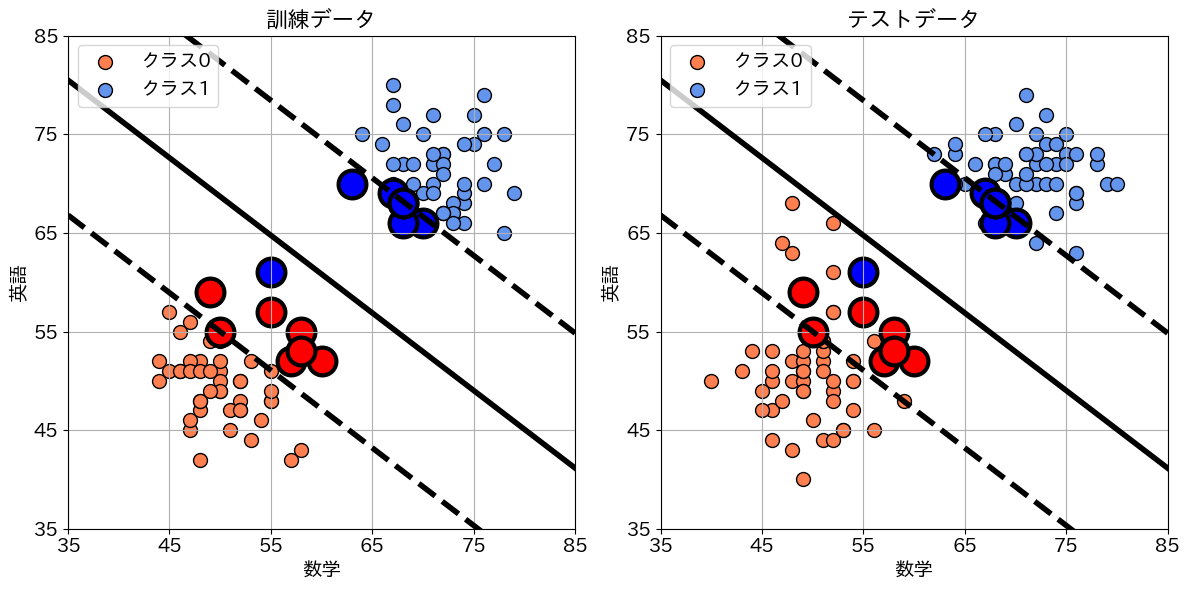

テストデータについての分類性能
混同行列
[[50  0]
 [ 0 50]]
正解率: 1.0
精度: [1. 1.]
再現率: [1. 1.]
F1値: [1. 1.]


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# 分類器を生成
model=SVC(kernel='linear', # 線形SVMを指定
          C=0.001)       # 正則化項。

# 訓練データで学習し、決定境界を求める
model.fit(x_train,y_train)

# データと決定境界、サポートベクトルを可視化する
plot_2class_result(x_train, y_train, x_test, y_test, model)

print('テストデータについての分類性能')
# テストデータに対してクラスを予測。結果をy_test_predに代入
y_test_pred=model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision=precision_score(y_test, y_test_pred, average=None)
test_recall=recall_score(y_test, y_test_pred, average=None)
test_f1=f1_score(y_test, y_test_pred, average=None)
test_cm=confusion_matrix(y_test, y_test_pred)

print('混同行列')
print(test_cm)
print('正解率:', test_accuracy)
print('精度:', test_precision)
print('再現率:', test_recall)
print('F1値:', test_f1)

# 実習8.4：分類性能の評価用関数を実装

正解率
0.75

精度
   0    1
1.00 0.67

再現率
   0    1
0.50 1.00

F1値
   0    1
0.67 0.80


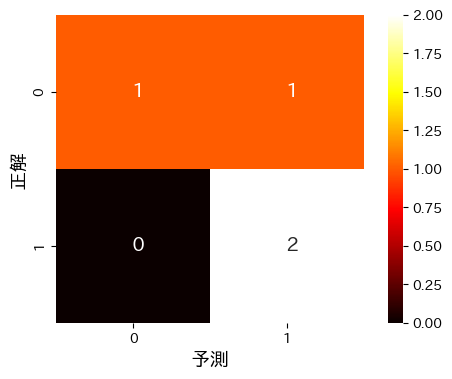

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calc_score(y_true, y_pred, class_labels, name, func):
    """ある指標の値をクラスごとに計算する。
    Args:
        y_true (ndarray): 目的変数（正解）
        y_pred (ndarray): 予測値
        class_labels (list): クラスラベル（文字列）を格納したリスト
        name (str): 指標の名前
        func (sklearn.metrics): 指標を計算する関数
    """
    # 指標の計算。average=None クラスごとに値を計算する
    score=func(y_true, y_pred, average=None)

    # 書式整形してクラスごとの値を表示する
    score_str = []
    for i in range(y_true.max()+1):
        score_str.append(f'{score[i]:.2f}')

    print('\n' + name)
    print(' '.join(class_labels))
    print(' '.join(score_str))

def evaluate(y_true, y_pred):
    """分類性能の評価用関数。混同行列・正解率・精度・再現率・F1値を計算し、表示する。
    Args:
        y_true (ndarray): 目的変数（正解）
        y_pred (ndarray): 予測値
    """

    # 混同行列の計算
    cm=confusion_matrix(y_true, y_pred)

    # 正解率の計算
    accuracy = accuracy_score(y_true, y_pred)
    print('正解率')
    print(f'{accuracy}')

    # 精度と再現率の表示用にクラスラベルを生成
    class_labels=[]
    for i in range(y_true.max()+1):
        class_labels.append(f'{i:4d}') # 空白を含め最低4桁で表示

    # 精度の計算。average=None クラスごとに値を計算する
    calc_score(y_true, y_pred, class_labels, '精度', precision_score)

    # 再現率の計算。average=None クラスごとに値を計算する
    calc_score(y_true, y_pred, class_labels, '再現率', recall_score)

    # F1値の計算。
    calc_score(y_true, y_pred, class_labels, 'F1値', f1_score)

    # 混同行列を可視化する
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot', annot_kws={'size':14})
    plt.xlabel('予測', fontsize=14)
    plt.ylabel('正解', fontsize=14)
    plt.show()

# 定義した関数をテスト
y_true=np.array([1,1,0,0]) # テスト用の正解ラベル
y_pred=np.array([1,1,1,0]) # テスト用の予測ラベル
evaluate(y_true, y_pred)

# 実習8.5：前処理が必要なデータの読み込みと可視化

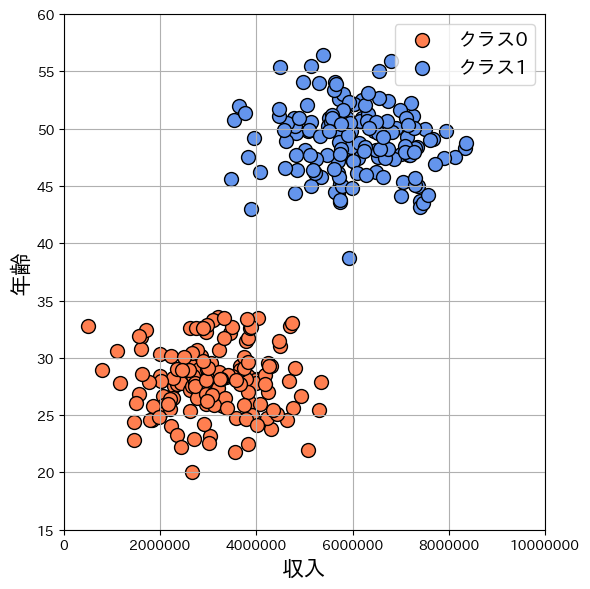

In [22]:
df2 = pd.read_csv('dm8-2.csv', encoding='utf-8')

x=df2[['収入', '年齢']].to_numpy() # 説明変数
y=df2['クラス'].to_numpy()         # 目的変数

# データの可視化
plot_income_age(x, y) # 説明変数と目的変数

# 実習8.6：前処理なしで分類

正解率
0.93

精度
   0    1
0.93 0.93

再現率
   0    1
0.93 0.93

F1値
   0    1
0.93 0.93


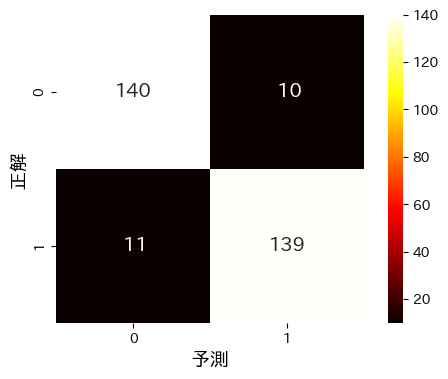

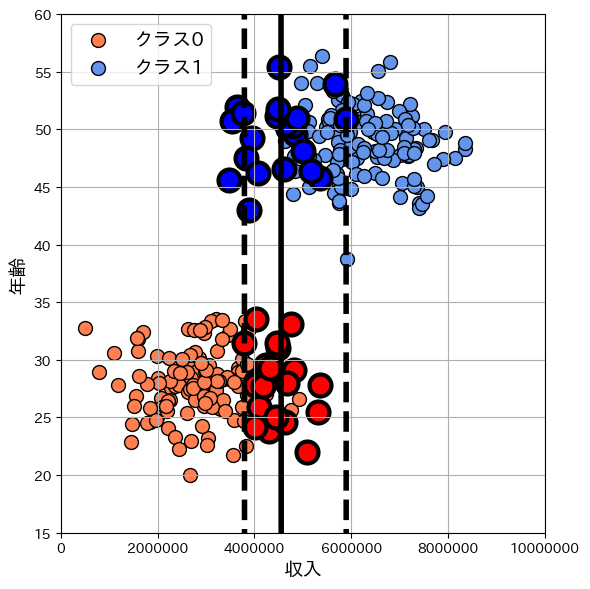

In [15]:
from sklearn.svm import SVC

model=SVC(kernel='linear',C=0.01)

model.fit(x,y) # 訓練データで学習し、決定境界を求める

y_pred=model.predict(x) # 各説明変数を使ってクラスラベルを予測

evaluate(y, y_pred) # 分類性能を評価

# 分類結果を可視化する
plot_income_age_result(x, y,  # 説明変数と目的変数
                       model, # 学習したモデル
                       xlim=(0,1e7), # X軸（収入）のプロット範囲
                       ylim=(15,60)) # Y軸（年齢）のプロット範囲

# 実習8.7：標準化して分類

正解率
1.0

精度
   0    1
1.00 1.00

再現率
   0    1
1.00 1.00

F1値
   0    1
1.00 1.00


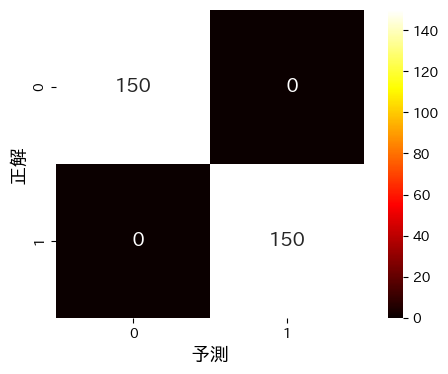

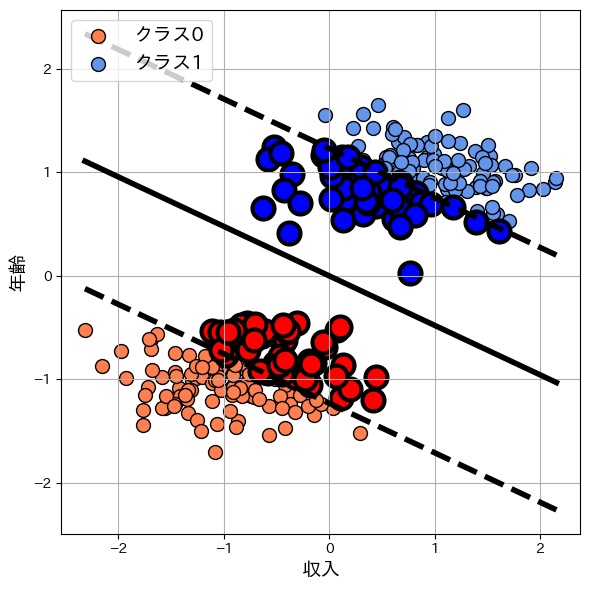

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 説明変数を成分ごとに標準化（実習3.3参照）
x_std=StandardScaler().fit_transform(x)

model=SVC(kernel='linear',C=0.01)
model.fit(x_std,y) # 標準化した訓練データで学習し、決定境界を求める

# 標準化した各説明変数を使ってクラスラベルを予測
y_pred=model.predict(x_std)

evaluate(y, y_pred) # 分類性能を評価

# 分類結果を可視化する
plot_income_age_result(x_std, y, model)

# 実習8.8：キノコの分類

***DMCODE 1700300929.11493
正解率
0.9858256555634302

精度
   0    1
0.99 0.98

再現率
   0    1
0.99 0.98

F1値
   0    1
0.99 0.98


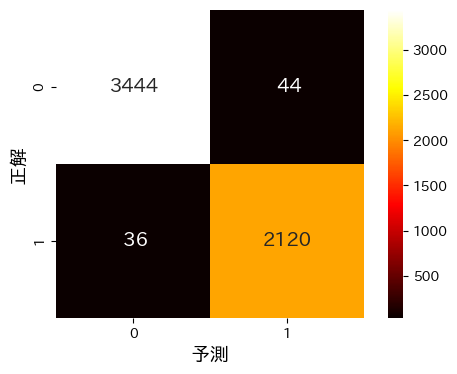

In [23]:
dmcode()

# 以降に必要なインポート文やコードを記述すること
df2 = pd.read_csv('dm8-3.csv', encoding='utf-8')

col_names = list(df2.columns)
col_names.remove('class')
x=df2[col_names].to_numpy()
y=df2['class'].to_numpy()

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# 説明変数を成分ごとに標準化（実習3.3参照）
x_std=StandardScaler().fit_transform(x)

model=SVC(kernel='linear',C=1)
model.fit(x_std,y) # 標準化した訓練データで学習し、決定境界を求める

# 標準化した各説明変数を使ってクラスラベルを予測
y_pred=model.predict(x_std)

evaluate(y, y_pred) # 分類性能を評価